# Training LSTM with Constrained Weights

In this part, we aim to train LSTM (Long Short Term Memory RNNs) where some of its weights are constrained over certain manifolds. Generally speaking, a LSTM is more complex than an simple RNN:
* it is composed by cell states and gates
* it has the purpose to LEARN what to remember and forget reduntant information
* it uses SIGMOID functions instead of TANH
* Composition of the cell in LSTM:
    * the cell has 2 outputs: the cell state and the hidden state
    
    1. Forget Gate (`Xt + ht-1`): desides what information to FORGET; the closer to 0 is forget, the closer to 1 is remain
    2. Input Gate (`Xt + ht-1`): creates a candidate with what information to remain
    3. Current Cell State: `ft*Ct-1 + it*Ct`
    4. Output Gate (`(Xt + ht-1) * ct`): desides what the next hidden state should be (which contains info about previous inputs)
    
> Note: [Check THIS blog post for more detailed explanation.](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21).

Here we consider bidirectional LSTMs, which are an extension of traditional LSTMs that can improve model performance on sequence classification problems. They train the model *forward* and *backward* on the same input (so for 1 layer LSTM we get 2 hidden and cell states)

<img src='https://i.imgur.com/z6iDAQB.png' width=400>


Below is a schema of how the example code works

<img src='https://i.imgur.com/AEtXhKH.png' width=500>

## Importing modules
We first import all the necessary modules for training LSTM. 

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

from torch.nn.parameter import Parameter

# To display youtube videos
from IPython.display import YouTubeVideo
from cdopt.manifold_torch import euclidean_torch, stiefel_torch
from cdopt.utils_torch.nn.modules import RNN_cdopt, LSTM_cdopt


def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


## Define the network

Define a neurnal with constrained weights are quite simple via CDOpt, we only need the following two procedures:
1. Replace the layers in `torch.nn` by the layers from `cdopt.utils_torch.nn` and specify the `manifold_class` options. 
2. Add the `layer.quad_penalty()` to the loss function.

In [2]:
# Customized transform (transforms to tensor, here you can normalize, perform Data Augmentation etc.)
my_transform = transforms.Compose([transforms.ToTensor()])

# Download data
mnist_train = torchvision.datasets.MNIST('data', train = True, download=True, transform=my_transform)
mnist_test = torchvision.datasets.MNIST('data', train = False, download=True, transform=my_transform)

In [3]:
class LSTM_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM_MNIST, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        
        # Step1: the LSTM model
        self.lstm = LSTM_cdopt(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional, manifold_class = stiefel_torch)
        
        # Step2: the FNN
        if bidirectional: # we'll have 2 more layers
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
            
            
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Set initial states
        if self.bidirectional:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size)
        else:
            # Hidden state:
            hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
            # Cell state:
            cell_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)

        hidden_state = hidden_state.to(device)
        cell_state = cell_state.to(device)

        if prints: print('hidden_state t0 shape:', hidden_state.shape, '\n' +
                         'cell_state t0 shape:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images, (hidden_state, cell_state))
        if prints: print('LSTM: output shape:', output.shape, '\n' +
                         'LSTM: last_hidden_state shape:', last_hidden_state.shape, '\n' +
                         'LSTM: last_cell_state shape:', last_cell_state.shape)
        # Reshape
        output = output[:, -1, :]
        if prints: print('output reshape:', output.shape)
        
        # FNN:
        output = self.layer(output)
        if prints: print('FNN: Final output shape:', output.shape)
        
        return output

## One-pass test

We then test how our LSTM works with given samples. We take a single batch of the images from the MINST dataset and observe the outputs of the LSTM network. 

In [4]:
# ====== STATICS ======
batch_size = 64
input_size = 28       # width of image
hidden_size = 128     # number of hidden neurons
layer_size = 2        # number of layers
output_size = 10      # possible choices
# =====================

In [5]:
# Taking a single batch of the images
train_loader_example = torch.utils.data.DataLoader(mnist_train, batch_size=64)
images, labels = next(iter(train_loader_example))
print('original images shape:', images.shape)
# Remove channel from shape
images = images.reshape(-1, 28, 28).to(device)
print('reshaped images shape:', images.shape, '\n')

# Creating the Model
lstm_example = LSTM_MNIST(input_size, hidden_size, layer_size, output_size)
lstm_example.to(device) 
print('lstm_example:', lstm_example, '\n')

# Making log predictions:
out = lstm_example(images, prints=True)

original images shape: torch.Size([64, 1, 28, 28])
reshaped images shape: torch.Size([64, 28, 28]) 

lstm_example: LSTM_MNIST(
  (lstm): LSTM_cdopt(28, 128, num_layers=2, batch_first=True, bidirectional=True)
  (layer): Linear(in_features=256, out_features=10, bias=True)
) 

images shape: torch.Size([64, 28, 28])
hidden_state t0 shape: torch.Size([4, 64, 128]) 
cell_state t0 shape: torch.Size([4, 64, 128])
LSTM: output shape: torch.Size([64, 28, 256]) 
LSTM: last_hidden_state shape: torch.Size([4, 64, 128]) 
LSTM: last_cell_state shape: torch.Size([4, 64, 128])
output reshape: torch.Size([64, 256])
FNN: Final output shape: torch.Size([64, 10])


## Training on ALL IMAGES

In [6]:
def get_accuracy(out, actual_labels, batchSize):
    '''Saves the Accuracy of the batch.
    Takes in the log probabilities, actual label and the batchSize (to average the score).'''
    predictions = out.max(dim=1)[1]
    correct = (predictions == actual_labels).sum().item()
    accuracy = correct/batch_size
    
    return accuracy

def train_network(model, train_data, test_data, batchSize=64, num_epochs=1, learning_rate=0.0005):
    
    '''Trains the model and computes the average accuracy for train and test data.'''
    
    print('Get data ready...')
    # Create dataloader for training dataset - so we can train on multiple batches
    # Shuffle after every epoch
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batchSize, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batchSize, shuffle=True, drop_last=True)
    
    # Create criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    
    print('Training started...')
    # Train the data multiple times
    for epoch in range(num_epochs):
        
        # Save Train and Test Loss
        train_loss = 0
        train_acc = 0

        
        # Set model in training mode:
        model.train()

        
        
        for k, (images, labels) in enumerate(train_loader):
            
            # Get rid of the channel
            images = images.view(-1, 28, 28)
            images = images.to(device)
            labels = labels.to(device)
            # print(labels.device)
            # Create log probabilities
            out = model(images)
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels) + 0.5 * model.lstm.quad_penalty()
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save Loss & Accuracy after each iteration
            train_loss += loss.item()
            train_acc += get_accuracy(out, labels, batchSize)
            
        
        # Print Average Train Loss & Accuracy after each epoch
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f} | Accuracy: {:.2f}'.format(epoch+1, num_epochs, train_loss/k, train_acc/k))
            
            
    print('Testing Started...')
    # Save Test Accuracy
    test_acc = 0
    # Evaluation mode
    model.eval()
    
    for k, (images, labels) in enumerate(test_loader):
        # Get rid of the channel
        images = images.view(-1, 28, 28)
        images = images.to(device)
        labels = labels.to(device)
        # Create logit predictions
        out = model(images)
        # Add Accuracy of this batch
        test_acc += get_accuracy(out, labels, batchSize)
        
    # Print Final Test Accuracy
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc/k) )

In [7]:
# ==== STATICS ====
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Instantiate the model
# We'll use TANH as our activation function
lstm_rnn = LSTM_MNIST(input_size, hidden_size, layer_size, output_size)
lstm_rnn.to(device)
# ==== TRAIN ====
train_network(lstm_rnn, mnist_train, mnist_test, num_epochs=10)

Get data ready...
Training started...
TRAIN | Epoch: 1/10 | Loss: 0.63 | Accuracy: 0.80
TRAIN | Epoch: 2/10 | Loss: 0.16 | Accuracy: 0.95
TRAIN | Epoch: 3/10 | Loss: 0.12 | Accuracy: 0.97
TRAIN | Epoch: 4/10 | Loss: 0.09 | Accuracy: 0.98
TRAIN | Epoch: 5/10 | Loss: 0.08 | Accuracy: 0.98
TRAIN | Epoch: 6/10 | Loss: 0.07 | Accuracy: 0.98
TRAIN | Epoch: 7/10 | Loss: 0.06 | Accuracy: 0.98
TRAIN | Epoch: 8/10 | Loss: 0.05 | Accuracy: 0.99
TRAIN | Epoch: 9/10 | Loss: 0.05 | Accuracy: 0.99
TRAIN | Epoch: 10/10 | Loss: 0.04 | Accuracy: 0.99
Testing Started...
TEST | Average Accuracy per 155 Loaders: 0.98407


In [8]:
lstm_rnn.lstm.quad_penalty()

tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)

## Confusion Matrix

A good way to visualize better how the model is performing is through a confusion matrix. So, you can see how well each label is predicted and what labels the model confuses with other labels.

In [17]:
def get_confusion_matrix(model, test_data):
    # First we make sure we disable Gradient Computing
    torch.no_grad()
    
    # Model in Evaluation Mode
    model.eval()
    
    preds, actuals = [], []

    for image, label in mnist_test:
        image = image.to(device)
        # label = label.to(device)
        image = image.view(-1, 28, 28)
        out = model(image)

        prediction = torch.max(out, dim=1)[1].item()
        preds.append(prediction)
        actuals.append(label)
    
    return sklearn.metrics.confusion_matrix(preds, actuals)

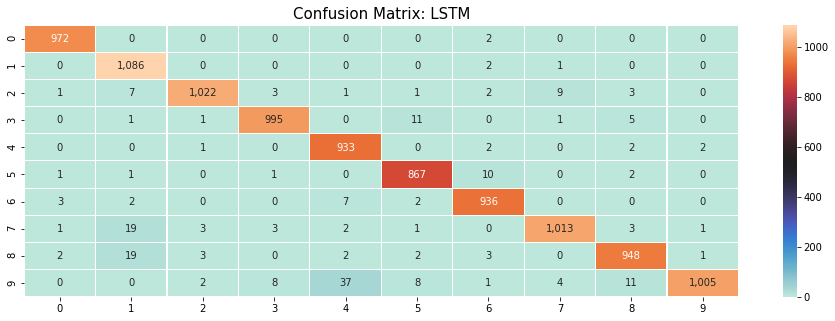

In [18]:
plt.figure(figsize=(16, 5))
sns.heatmap(get_confusion_matrix(lstm_rnn, mnist_test), cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: LSTM', fontsize=15)

## Reference

1. https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99
2. Jing L, Gulcehre C, Peurifoy J, et al. Gated orthogonal recurrent units: On learning to forget[J]. Neural computation, 2019, 31(4): 765-783.
3. Hu X, Xiao N, Liu X, Toh KC. A Constraint Dissolving Approach for Nonsmooth Optimization over the Stiefel Manifold[J]. arXiv preprint arXiv:2205.10500, 2022.